In [26]:
import pandas

import numpy
import pygsheets
import datetime
import scipy
import sklearn.linear_model
import sklearn.cluster

import matplotlib.pyplot as mp

# import pipelines dataset

In [27]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')

gas_pipes = spreadsheet.worksheet('title', 'Gas pipelines').get_as_df(start='A2')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A2')

gas_pipes = gas_pipes.drop('WKTFormat', axis=1) # delete WKTFormat column
oil_pipes = oil_pipes.drop('WKTFormat', axis=1)
pipes_df_orig = gas_pipes.copy()

# remove empty cells for pipes, owners
pipes_df_orig = pipes_df_orig[pipes_df_orig['PipelineName']!='']
pipes_df_orig = pipes_df_orig.loc[pipes_df_orig.Fuel=='Gas']

#get other relevant sheets
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()

In [28]:
country_ratios_df.replace('--', numpy.nan, inplace=True)
pipes_df_orig.replace('--',numpy.nan,inplace=True)
pipes_df_orig['ProposalYear'] = pipes_df_orig['ProposalYear'].replace('',numpy.nan)
region_df_orig = spreadsheet.worksheet('title', 'Region dictionary').get_as_df(start='A2')

In [29]:
region_df_eu = region_df_orig.copy()[region_df_orig['EuropeanUnion']=='Yes']
region_df_egt = region_df_orig.copy()[region_df_orig['EuroGasTracker']=='Yes']
region_df_europe = region_df_orig.copy()[region_df_orig['Region']=='Europe']
region_df_eu_uk = region_df_orig.copy()[(region_df_orig['Region']=='Europe') | 
                                          (region_df_orig['Country'].isin(['United Kingdom','Israel']))]

In [30]:
region_df_touse = region_df_eu.copy()

In [31]:
# subset the pipelines to use
pipes_df_touse = pipes_df_orig.loc[
    ~pipes_df_orig['Countries'].apply(
        lambda x: set(x.split(', ')).isdisjoint(set(region_df_touse['Country'].tolist()))
    )]

pipes_df_touse = pipes_df_touse.loc[pipes_df_touse.Fuel=='Gas']
country_ratios_df_touse = country_ratios_df.loc[(country_ratios_df.Country.isin(region_df_touse['Country'].tolist()))&
                                                (country_ratios_df.Fuel=='Gas')]

In [32]:
western_eu = ['Ireland', 'France', 'Belgium', 'Netherlands', 
              'Luxembourg', 'Germany', 'Austria'] 

eastern_eu = ['Estonia', 'Latvia', 'Lithuania', 'Poland', 'Czech Republic', 
              'Slovakia', 'Slovenia', 'Croatia', 'Hungary', 'Romania', 'Bulgaria'] 

southern_eu = ['Portugal', 'Spain', 'Italy', 
               'Malta', 'Greece', 'Cyprus']

northern_eu = ['Sweden', 'Finland', 'Denmark']

### add double dagger to PCI5 projects???

In [33]:
double_dagger = u"\u2021"

In [34]:
pipes_df_touse.loc[pipes_df_touse.PCI5=='yes','PipelineName'] += ' ' + double_dagger

country_ratios_df_touse.loc[country_ratios_df_touse.ProjectID.isin(
                pipes_df_touse[pipes_df_touse.PCI5=='yes']['ProjectID'].tolist()), 'PipelineName'] += ' '+double_dagger


# cost estimates for EU 27 member states

## outliers and special cases

In [35]:
outliers_projectids = ['P3109', ]

# P3109 = Valchi Dol–Preselka Pipeline replacement project, not a good new pipeline cost estimate

### correct Poland-Ukraine Interconnector

In [36]:
# https://www.gem.wiki/Poland-Ukraine_Interconnector_Gas_Pipeline
# our country_ratios code calculates this is half in each country, but it's not
country_ratios_df_touse.loc[(country_ratios_df_touse.PipelineName=='Poland-Ukraine Interconnector Gas Pipeline')&
                      (country_ratios_df_touse.Country=='Poland'),'MergedKmByCountry'] = 1.5

country_ratios_df_touse.loc[(country_ratios_df_touse.PipelineName=='Poland-Ukraine Interconnector Gas Pipeline')&
                      (country_ratios_df_touse.Country=='Ukraine'),'MergedKmByCountry'] = 99.0

### correct Gas Interconnection Poland-Lithuania (our fractional calc doesn't get it right)

In [37]:
country_ratios_df_touse.loc[(country_ratios_df_touse.PipelineName=='Gas Interconnection Poland-Lithuania')&
                      (country_ratios_df_touse.Country=='Poland'),'MergedKmByCountry'] = 343.0

country_ratios_df_touse.loc[(country_ratios_df_touse.PipelineName=='Gas Interconnection Poland-Lithuania')&
                      (country_ratios_df_touse.Country=='Lithuania'),'MergedKmByCountry'] = 165.0

### pull out only pipelines with known length and cost

In [38]:
# pull out only pipelines that have a KNOWN LENGTH AND COST and are in the EU27
country_ratios_cost_calc = country_ratios_df_touse.loc[(~country_ratios_df_touse['CostEuroPerKm'].isnull())]

# Adriatica Pipeline is now fixed, no need to remove is as an outlier
country_ratios_cost_calc = country_ratios_cost_calc[~country_ratios_cost_calc.ProjectID.isin(outliers_projectids)]

### get cost value per country for calculating country-specific pipeline costs

In [39]:
country_level_pipeline_costs_df = pandas.DataFrame(numpy.nan, index=region_df_touse['Country'].tolist(), columns=['EstCostInEachCountry', 'NumValues'])

country_level_pipeline_costs_df['EstCostInEachCountry'] = country_ratios_cost_calc.groupby('Country')['CostEuroPerKm'].mean()/1.e6
country_level_pipeline_costs_df['NumValues'] = country_ratios_cost_calc.groupby('Country')['CostEuroPerKm'].count()
country_level_pipeline_costs_df

,EstCostInEachCountry,NumValues
Austria,5.974867,1.0
Belgium,NaN,NaN
Bulgaria,1.197424,14.0
Croatia,1.554600,9.0
Cyprus,3.114682,5.0
Czech Republic,3.300812,4.0
Denmark,6.274576,4.0
Estonia,NaN,NaN
Finland,9.917435,2.0
France,2.913084,5.0


### exploring a mean weighted by km of the pipelines in question?

* if a given pipeline is super long and costs more than a short one per km, then should it be weighed more heavily in calculating the EU-average pipeline cost? the idea is that longer pipelines probably cost a significantly larger amount to build... look at the plot of that first perhaps

pipeline cost vs length?

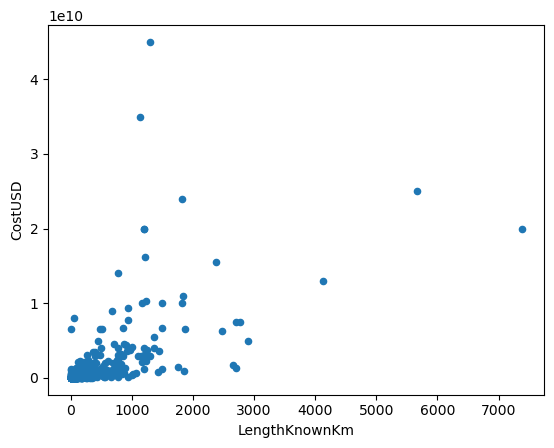

In [40]:
ax = pipes_df_orig.plot.scatter('LengthKnownKm','CostUSD')

### regression estimate: given length, estimate cost

In [41]:
pipes_df_toregress = pipes_df_touse.loc[(~pipes_df_touse.LengthKnownKm.isnull())&
                                       (~pipes_df_touse.CostEuro.isnull())&
                                       (pipes_df_touse.LengthKnownKm!=0)]

# # look at the full global dataset
# pipes_df_toregress = pipes_df_orig.loc[(~pipes_df_orig.LengthKnownKm.isnull())&
#                                         (~pipes_df_orig.CostEuro.isnull())&
#                                         (pipes_df_orig.LengthKnownKm!=0)]#&
#                                         #(pipes_df_orig.LengthKnownKm>100)&
#                                         #(pipes_df_orig.LengthKnownKm<1000)]

### gentle cluster analysis

In [42]:
num_clusters = 2
kmeans_cluster = sklearn.cluster.KMeans(n_clusters=num_clusters, 
                                        init='random', 
                                        n_init=10, 
                                        max_iter=300, 
                                        tol=1e-4,
                                       random_state=42)

km_fit = kmeans_cluster.fit_predict(X=pipes_df_toregress.LengthKnownKm.to_numpy().reshape(-1,1),
                   y=pipes_df_toregress.CostEuro.to_numpy().reshape(-1,1))

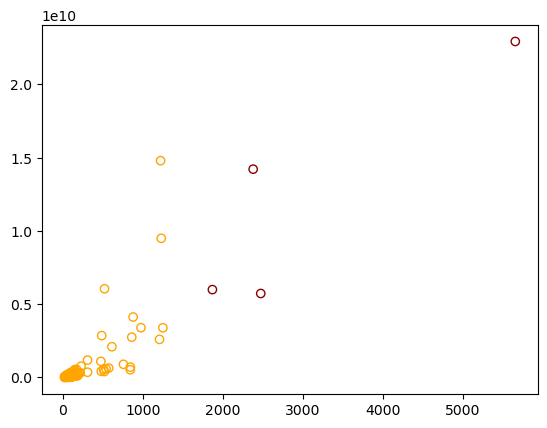

In [43]:
colors=['darkred','orange','green','blue','purple']

for i in range(num_clusters):
    mp.scatter(pipes_df_toregress.LengthKnownKm.to_numpy().reshape(-1,1)[km_fit == i],
               pipes_df_toregress.CostEuro.to_numpy().reshape(-1,1)[km_fit == i],
               edgecolor=colors[i], color='None')

#mp.xlim(0,1000)
#mp.ylim(0,0.5e10)
# mp.scatter(pipes_df_toregress.LengthKnownKm.to_numpy().reshape(-1,1)[km_fit == 2],
#            pipes_df_toregress.CostEuro.to_numpy().reshape(-1,1)[km_fit == 2],
#            color='slateblue', s=10)

In [56]:
pipes_df_toregress_dropdupes = pipes_df_toregress.drop_duplicates('CostEuroPerKm', keep='first')
pipes_df_toregress_dropdupes.CostEuroPerKm.mean()/1e6

1.9946533715525845

In [57]:
ts_estimator = sklearn.linear_model.TheilSenRegressor(random_state=42, fit_intercept=False)
ts_estimator.fit(X=pipes_df_toregress.LengthKnownKm.to_numpy().reshape(-1,1),
                 y=pipes_df_toregress.CostEuro.to_numpy().reshape(-1,1))

r_estimator = sklearn.linear_model.RANSACRegressor(random_state=42,
                                                   estimator=sklearn.linear_model.LinearRegression(fit_intercept=False))
r_estimator.fit(X=pipes_df_toregress.LengthKnownKm.to_numpy().reshape(-1,1),
                y=pipes_df_toregress.CostEuro.to_numpy().reshape(-1,1))

ols_estimator = sklearn.linear_model.LinearRegression(fit_intercept=False)
ols_estimator.fit(X=pipes_df_toregress.LengthKnownKm.to_numpy().reshape(-1,1),
                  y=pipes_df_toregress.CostEuro.to_numpy().reshape(-1,1))

ts_slope, ts_intercept, ts_low_slope, ts_high_slope = scipy.stats.mstats.theilslopes(y=pipes_df_toregress.CostEuro.tolist(), 
                                                                            x=pipes_df_toregress.LengthKnownKm.tolist(),
                                                                            alpha=0.1, )

s_slope, s_intercept = scipy.stats.mstats.siegelslopes(y=pipes_df_toregress.CostEuro.tolist(), 
                                                       x=pipes_df_toregress.LengthKnownKm.tolist())

/Users/baird/mambaforge/envs/gem/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [58]:
pipes_df_toregress_dropdupes = pipes_df_toregress.drop_duplicates('CostEuroPerKm', keep='first')
pipes_df_toregress_dropdupes.CostEuroPerKm.mean()/1e6

1.9946533715525845

[[4.38314333]] OLS
[1.32432005] TS
[[1.11347366]] R
2.110610498155798 scipy TS slope


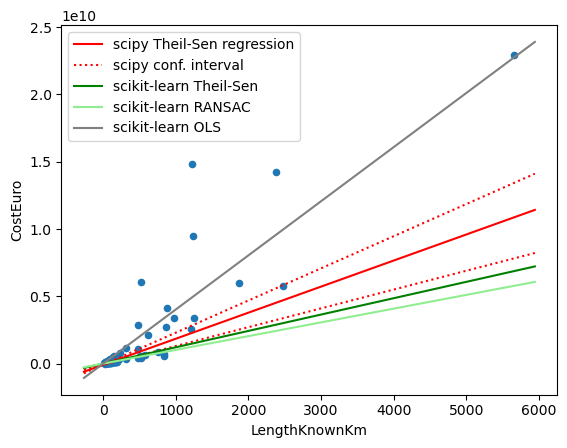

In [60]:
ax = pipes_df_toregress_dropdupes.plot.scatter('LengthKnownKm','CostEuro')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

#ax.set_xlim(0,200)
#ax.set_ylim(0,0.4e9)
xvals = numpy.linspace(xmin,xmax,1000)

ts_pred = ts_estimator.predict(xvals.reshape(-1,1))
r_pred = r_estimator.predict(xvals.reshape(-1,1))
ols_pred = ols_estimator.predict(xvals.reshape(-1,1))

ax.plot(xvals, ts_slope*xvals+ts_intercept, label = 'scipy Theil-Sen regression', c='red')
ax.plot(xvals, ts_low_slope*xvals+ts_intercept, label='scipy conf. interval', c='red', ls=':')
ax.plot(xvals, ts_high_slope*xvals+ts_intercept, c='red', ls=':')

ax.plot(xvals, ts_pred, label='scikit-learn Theil-Sen', c='green')
ax.plot(xvals, r_pred, label='scikit-learn RANSAC', c='lightgreen')
ax.plot(xvals, ols_pred, label='scikit-learn OLS', c='gray')

#ax.plot(

#ax.plot(xvals, s_slope*xvals+s_intercept, label = 'scipy.stats', c='orange')

ax.legend()

print(ols_estimator.coef_/1e6*1.09, "OLS")
print(ts_estimator.coef_/1e6*1.09, "TS")
print(r_estimator.estimator_.coef_/1e6*1.09, "R")
print(ts_slope/1e6*1.09, "scipy TS slope")

drop duplicates

drop duplicates first

## pick out high/low quantiles

list the costs in order:

remove duplicates from dataframe

In [ ]:
country_ratios_cost_calc_dropdupes = country_ratios_cost_calc.drop_duplicates('CostEuroPerKm', keep='first')

In [ ]:
temp_df = country_ratios_cost_calc.drop_duplicates('CostEuroPerKm', keep='first')
qlo_val = 0.025
qhi_val = 0.975

q_lo=temp_df['CostEuroPerKm'].quantile(qlo_val)
q_hi=temp_df['CostEuroPerKm'].quantile(qhi_val)
print(temp_df['CostEuroPerKm'].quantile(qlo_val))
print(temp_df['CostEuroPerKm'].quantile(qhi_val))

temp_df_trimmed = temp_df.loc[temp_df['CostEuroPerKm'].between(q_lo, q_hi, inclusive='neither')]

In [ ]:
scipy.stats.trim_mean(temp_df.CostEuroPerKm.tolist(), proportiontocut=0.05)/1e6

In [ ]:
temp_df_trimmed.CostEuroPerKm.mean()/1e6

In [ ]:
country_ratios_cost_calc_dropdupes['CostEuroPerKm'].mean()/1e6

In [ ]:
country_level_pipeline_costs_df = country_ratios_df_touse.groupby('Country')[['CostEuroPerKm']].mean()/1e6
country_level_pipeline_costs_df.mean()

### now use these country-specific costs as multipliers on within-country kilometers

In [ ]:
mean_cost_per_km = country_ratios_cost_calc_
#country_level_pipeline_costs_df['EstCostInEachCountry'].mean() # in millions of Euro

#country_ratios_df_eu27 = country_ratios_df.copy()[(country_ratios_df['Country'].isin(region_df_touse['Country'].tolist())) &
#                                                  (country_ratios_df['Fuel']=='Gas')]

country_ratios_df_touse['TotalEstCostEuroMillions'] = numpy.nan

for idx,row in country_ratios_df_eu27.iterrows():
    country_ratios_df_eu27.loc[idx,'TotalEstCostEuroMillions'] = row['MergedKmByCountry'] * mean_cost_per_km

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~country_ratios_df_eu27['CostEuroPerKm'].isna()
country_ratios_df_eu27.loc[costs_exist_TF,'TotalEstCostEuroMillions'] = \
    country_ratios_df_eu27[costs_exist_TF]['CostEuroPerKm']/1e6 * \
    country_ratios_df_eu27[costs_exist_TF]['MergedKmByCountry']

# add in Trans-Adriatic estimated cost:
country_ratios_df_eu27.loc[(country_ratios_df_eu27['PipelineName']=='Trans-Adriatic Gas Pipeline')&
                            (country_ratios_df_eu27['SegmentName']=='TAP Expansion')&
                            (country_ratios_df_eu27['Country']=='Italy'),'Country'] = 'Italy, Greece'
country_ratios_df_eu27.loc[(country_ratios_df_eu27['PipelineName']=='Trans-Adriatic Gas Pipeline')&
                            (country_ratios_df_eu27['SegmentName']=='TAP Expansion')&
                            (country_ratios_df_eu27['Country']=='Italy, Greece'), 'TotalEstCostEuroMillions'] = \
country_ratios_df.loc[(country_ratios_df.ProjectID=='P3203'),'CostEuro'].values[0]/1e6# * 2/3 * 0.5 # greece and italy, not albania

greece_idx = country_ratios_df_eu27.index[(country_ratios_df_eu27['PipelineName']=='Trans-Adriatic Gas Pipeline')&
                            (country_ratios_df_eu27['SegmentName']=='TAP Expansion')&
                            (country_ratios_df_eu27['Country']=='Greece')]
country_ratios_df_eu27.drop(index=greece_idx, inplace=True)

# finally, get rid of any pipeline segments that are zero in a given country, except TAP
country_ratios_df_eu27 = country_ratios_df_eu27[(country_ratios_df_eu27['PipelineName']=='Trans-Adriatic Gas Pipeline')|
                                                (country_ratios_df_eu27['MergedKmByCountry']!=0)]


In [ ]:
mean_cost_per_km # in million Euro

In [ ]:
output_columns = ['Country',
                  'PipelineName',
                  'SegmentName',
                  'Status',
                  'CapacityBcm/y',
                  'MergedKmByCountry',
                  'TotalEstCostEuroMillions']
country_ratios_df_eu27_excel = country_ratios_df_eu27[country_ratios_df_eu27['Status'].isin(['Proposed','Construction'])]
country_ratios_df_eu27_excel = country_ratios_df_eu27_excel.sort_values(['Status','PipelineName','TotalEstCostEuroMillions'], ascending=[True,True,False])
country_ratios_df_eu27_excel.replace(numpy.nan, '')
country_ratios_df_eu27_excel = country_ratios_df_eu27_excel[output_columns]

#country_ratios_cost_calc_excel = country_ratios_cost_calc_excel.groupby('Status')
#print(country_ratios_cost_calc_excel)
#country_ratios_df_eu27_excel.to_excel('EGT-km-and-cost-per-country'+str(datetime.date.today())+'.xlsx', index=False)

## print export, import, and within-EU pipelines

planned pipelines to import gas into the EU

In [ ]:
# get the pipelines that import into the EU, export out, and are completely within
pipes_df_eu_imports = pipes_df_orig.copy()[(pipes_df_orig['Fuel']=='Gas')&
              (~pipes_df_orig['StartCountry'].isin(region_df_touse.Country))&
              (pipes_df_orig['EndCountry'].isin(region_df_touse.Country))]

pipes_df_eu_exports = pipes_df_orig.copy()[(pipes_df_orig['Fuel']=='Gas')&
              (pipes_df_orig['StartCountry'].isin(region_df_touse.Country))&
              (~pipes_df_orig['EndCountry'].isin(region_df_touse.Country))]

pipes_df_eu_within = pipes_df_orig.copy()[(pipes_df_orig['Fuel']=='Gas')&
              (pipes_df_orig['StartCountry'].isin(region_df_touse.Country))&
              (pipes_df_orig['EndCountry'].isin(region_df_touse.Country))]

## creating Table 5 (appendix)

In [ ]:
# pipes_df_eu_imports.loc[pipes_df_eu_imports.Status.isin(
#['Proposed','Construction'])].ProjectID

# only construction, proposed project IDs here, built on a list:
import_projectids = [
'P0463',
'P0479',
'P0684',
'P0702',
'P0732',
'P0827',
'P1321',
'P1324',
#'P1773', # this is the Siret-Khotyn Gas Pipeline, doesn't count
'P2264',
'P3335',
'P2727', # Gheraesti-Siret Gas Pipeline (Ukraine to Romania, bidirectional), added manually
#'P3522', # UK-Ireland interconnector
'P3203' # Trans-Adriatic Gas Pipeline TAP Expansion
]

all_other_projectids = list(set(country_ratios_df_eu27.loc[
    country_ratios_df_eu27.Status.isin(['Proposed','Construction'])].ProjectID) - set(import_projectids))

output_columns = ['Country',
                  'PipelineName',
                  'CapacityBcm/y',
                  'MergedKmByCountry',
                  'TotalEstCostEuroMillions']

country_ratios_df_eu27.loc[country_ratios_df_eu27.ProjectID.isin(import_projectids)].sort_values(['Status','PipelineName','TotalEstCostEuroMillions'], ascending=[True,True,False])[output_columns].replace(numpy.nan,'').style.hide_index()

## creating Table 7 (appendix)

### longer than 150 km

In [ ]:
#projectids_threshold = list(
#    set(country_ratios_df_eu27.loc[country_ratios_df_eu27.MergedKmByCountry>75]['ProjectID'])
#)
#
#projectids_threshold = list(
#    set(country_ratios_df_eu27.loc[country_ratios_df_eu27.MergedKmByCountry>100]['ProjectID'])
#)

# must be longer than 150 total, and the segment must be located within the EU
projectids_threshold = list(
    set(country_ratios_df_eu27.loc[(country_ratios_df_eu27.MergedKmByPipeline>150)&
                                   (country_ratios_df_eu27.ProjectID.isin(all_other_projectids))]['ProjectID'])
)

projectids_under_threshold = list(
    set(all_other_projectids) - set(projectids_threshold)
)

projectids_threshold.__len__()

In [ ]:
output_columns = ['Country',
                  'PipelineName',
                  #'SegmentName',
                  #'Status',
                  'CapacityBcm/y',
                  'MergedKmByPipeline',
                  'MergedKmByCountry',
                  'TotalEstCostEuroMillions']

#country_ratios_df_eu27.replace(numpy.nan, '', inplace=True)
country_ratios_df_eu27.replace(numpy.nan,'').loc[(country_ratios_df_eu27.ProjectID.isin(projectids_threshold))].sort_values(['Status','PipelineName','TotalEstCostEuroMillions'], ascending=[True,True,False])[output_columns].style.hide_index()


### shorter than 150 km

In [ ]:
below_threshold_df = country_ratios_df_eu27.loc[country_ratios_df_eu27.ProjectID.isin(projectids_under_threshold)]#.groupby('Status')

below_threshold_df.groupby('Status')[['MergedKmByCountry','TotalEstCostEuroMillions']].sum()

In [ ]:
country_ratios_df_eu27.loc[country_ratios_df_eu27.Status.isin(
    ['Proposed','Construction'])]['MergedKmByCountry'].sum()

# import terminals now

In [ ]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1tcS6Wd-Wp-LTDpLzFgJY_RSNDnbyubW3J_9HKIAys4A')
#spreadsheet = gc.open_by_key('1BHiidrJnzh96Em3KrqBpCoWaJ3GB5OeCY9dHVaEDEFs') # mar 22 2022 version for EGT

#spreadsheet[1] "Gas Pipelines" tab is the second index
terms_df_orig = spreadsheet.worksheet('title', 'Terminals').get_as_df(start='A2')

In [ ]:
# replace all -- with nans
terms_df_orig.replace('--', numpy.nan, inplace=True)
# only keep LNG terminals (remove oil)
terms_df_orig = terms_df_orig.loc[terms_df_orig.Fuel=='LNG']
# remove anything without a wiki page
terms_df_orig = terms_df_orig.loc[terms_df_orig.Wiki!='']
# remove N/A statuses
terms_df_orig = terms_df_orig.loc[terms_df_orig.Status!='']

In [ ]:
terms_df_orig.loc[terms_df_orig.PCI5=='yes','TerminalName'] += ' ' + double_dagger

In [ ]:
terms_df_orig.loc[terms_df_orig.PCI5=='yes','TerminalName']

In [ ]:
terms_df_eu27 = terms_df_orig.loc[(terms_df_orig['Country'].isin(region_df_touse['Country']))]

In [ ]:
mtpa_multiplier = 1/0.7352941863 # multiply by this to convert to bcm
euro_multiplier = 1/1.14 # multiply USD by this to get Euro, should be same as currency conversions in Sheet

In [ ]:
# pull out only import terminals within EU27
terms_cost_calc_eu27 = terms_df_eu27.loc[(terms_df_eu27['Import/Export']=='Import')]

In [ ]:
terms_cost_calc_eu27.loc[terms_cost_calc_eu27.Status=='Operating']['CapacityInBcm/y'].sum()

### outliers and special cases

In [ ]:
outliers_comboids = ['T068300'] # Ravenna=068300
terms_cost_calc_eu27 = terms_cost_calc_eu27.loc[~terms_cost_calc_eu27.ComboID.isin(outliers_comboids)]

### create onshore and floating dfs

In [ ]:
terms_cost_calc_eu27_onshore = terms_cost_calc_eu27.loc[terms_cost_calc_eu27['Floating']=='']
terms_cost_calc_eu27_floating = terms_cost_calc_eu27.loc[terms_cost_calc_eu27['Floating']=='yes']

### how many go into calculation - floating

In [ ]:
print(terms_cost_calc_eu27_floating.shape)
print(terms_cost_calc_eu27_floating[~terms_cost_calc_eu27_floating['CostUSDPerBcm/y'].isna()].shape)

terms_cost_calc_eu27_floating['CostMillionEuroPerBcm/y'] = numpy.nan
terms_cost_calc_eu27_floating['CostMillionEuroPerBcm/y'] = terms_cost_calc_eu27_floating.loc[:,'CostUSDPerBcm/y']*euro_multiplier / 1e6
# for floating terminals, remove anything that's missing a cost per bcm/y value
# none of these are expansions (probably very rare to have a FSRU/FLNG expansion?) so will not worry about that

#terms_cost_calc_eu27_floating.loc[(~terms_cost_calc_eu27_floating['CostUSDPerBcm/y'].isna())][['TerminalName', 'UnitName', 'Country', 'Status', 'Wiki','CostMillionEuroPerBcm/y']].style.hide_index()
terms_cost_calc_eu27_floating_noexpansions = terms_cost_calc_eu27_floating.loc[~terms_cost_calc_eu27_floating['UnitName'].str.contains('Expansion')]
terms_cost_calc_eu27_floating_noexpansions.loc[~terms_cost_calc_eu27_floating_noexpansions.loc[:,'CostUSDPerBcm/y'].isna()][['TerminalName', 'UnitName', 'Country', 'Status', 'Wiki','CostMillionEuroPerBcm/y']].style.hide_index()


In [ ]:
terms_cost_calc_eu27_floating_noexpansions[~terms_cost_calc_eu27_floating_noexpansions.loc[:,'CostUSDPerBcm/y'].isna()][['TerminalName', 'UnitName', 'Country', 'Status', 'CapacityInBcm/y', 'CostMillionEuroPerBcm/y']].style.hide_index()




### how many go into calculation - onshore

In [ ]:
print(terms_cost_calc_eu27_onshore.shape)
print(terms_cost_calc_eu27_onshore.loc[(~terms_cost_calc_eu27_onshore['CostUSDPerBcm/y'].isna()) &
                        (~terms_cost_calc_eu27_onshore['UnitName'].str.contains('Expansion'))].shape)

terms_cost_calc_eu27_onshore.loc[:,'CostMillionEuroPerBcm/y'] = terms_cost_calc_eu27_onshore.loc[:,'CostUSDPerBcm/y']*euro_multiplier / 1e6
# for floating terminals, remove anything missing cost per bcm/y AND anything that's an expansion project

terms_cost_calc_eu27_onshore_noexpansions = terms_cost_calc_eu27_onshore.loc[~terms_cost_calc_eu27_onshore['UnitName'].str.contains('Expansion')]
terms_cost_calc_eu27_onshore_noexpansions[~terms_cost_calc_eu27_onshore_noexpansions.loc[:,'CostUSDPerBcm/y'].isna()][['TerminalName', 'UnitName', 'Country', 'Status', 'Wiki','CostMillionEuroPerBcm/y']].style.hide_index()


In [ ]:
terms_cost_calc_eu27_onshore_noexpansions[~terms_cost_calc_eu27_onshore_noexpansions.loc[:,'CostUSDPerBcm/y'].isna()][['TerminalName', 'UnitName', 'Country', 
                                                                                                                       'Status', 'CapacityInBcm/y', 
                                                                                                                       'Wiki','CostMillionEuroPerBcm/y']].style.hide_index()



### t test to see if floating and onshore different

p value is >0.0285, seems statistically significant??

In [ ]:
scipy.stats.ttest_ind(terms_cost_calc_eu27_onshore[(~terms_cost_calc_eu27_onshore['CostMillionEuroPerBcm/y'].isna())]['CostMillionEuroPerBcm/y'].values,
                      terms_cost_calc_eu27_floating[(~terms_cost_calc_eu27_floating['CostMillionEuroPerBcm/y'].isna())]['CostMillionEuroPerBcm/y'].values)

### mean floating and onshore costs

In [ ]:
terms_cost_calc_eu27_floating_noexpansions['CostMillionEuroPerBcm/y'].mean() #* euro_multiplier

In [ ]:
terms_cost_calc_eu27_onshore_noexpansions['CostMillionEuroPerBcm/y'].mean() #* euro_multiplier

### calculate import terminal costs

In [ ]:
terms_df_eu27_import = terms_df_eu27.loc[terms_df_eu27['Import/Export']=='Import']

In [ ]:
terms_df_eu27_export = terms_df_eu27.loc[terms_df_eu27['Import/Export']=='Export']

In [ ]:
terms_df_eu27_import_future = terms_df_eu27_import.loc[
    terms_df_eu27_import['Status'].isin(['Proposed','Construction'])]

# do for floating
terms_df_eu27_import_future['CostMillionEuroTotal'] = numpy.nan
terms_df_eu27_import_future.loc[
    (terms_df_eu27_import_future['Floating']=='yes'), 'CostMillionEuroTotal'] = terms_df_eu27_import_future.loc[
    (terms_df_eu27_import_future['Floating']=='yes'), 'CapacityInBcm/y'] * terms_cost_calc_eu27_floating_noexpansions['CostMillionEuroPerBcm/y'].mean()

# now do for onshore
terms_df_eu27_import_future.loc[:,'CostMillionEuroTotal'] = numpy.nan
terms_df_eu27_import_future.loc[
    (terms_df_eu27_import_future['Floating']!='yes'), 'CostMillionEuroTotal'] = terms_df_eu27_import_future.loc[
    (terms_df_eu27_import_future['Floating']!='yes'), 'CapacityInBcm/y'] * terms_cost_calc_eu27_onshore_noexpansions['CostMillionEuroPerBcm/y'].mean()

# then replace any that we have already
terms_df_eu27_import_future['CostEstUSD'] = terms_df_eu27_import_future['CostEstUSD']*euro_multiplier/1.e6

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_eu27_import_future['CostEstUSD'].isna()
terms_df_eu27_import_future.loc[costs_exist_TF,'CostMillionEuroTotal'] = \
    terms_df_eu27_import_future[costs_exist_TF]['CostEstUSD']*euro_multiplier/1e6


### correct outliers/special cases

In [ ]:
# Zeebrugge terminal is 116 million for BOTH expansion projects
#T042601	https://www.gem.wiki/Fluxys_Zeebrugge_LNG_Terminal	Zeebrugge LNG Terminal, 2024 Expansion
#T042602	https://www.gem.wiki/Fluxys_Zeebrugge_LNG_Terminal	Zeebrugge LNG Terminal, 2026 Expansion
outliers_comboids = ['T042602']
terms_df_eu27_import_future.loc[
    terms_df_eu27_import_future.ComboID.isin(outliers_comboids),'CostMillionEuroTotal'] = 0.0


# creating table 6 (appendix)

In [ ]:
terms_df_eu27_import_future.columns

In [ ]:
terms_df_eu27_import_future['CapacityInBcm/y'].sum()

In [ ]:
output_columns = ['Country',
                'TerminalName',
                'UnitName',
                'CapacityInBcm/y',
                #'Status',
                'CostMillionEuroTotal']
terms_df_eu27_import_future.sort_values(['Status','TerminalName'], ascending=[True,True])[output_columns].replace(numpy.nan,'').style.hide_index()

In [ ]:
for i in sorted(terms_df_eu27_import_future.TerminalName): print(i)

# creating table 2 - future gas infra in EU countries

In [ ]:
terms_df_eu27_import_future.groupby(['Country'])['CapacityInBcm/y'].sum()
#terms_df_eu27_import_future.groupby('Country')['CapacityInMtpa'].sum()

In [ ]:
country_ratios_df_eu27.loc[country_ratios_df_eu27.ProjectID.isin(
    import_projectids+all_other_projectids)].groupby('Country')['TotalEstCostEuroMillions'].sum()

In [ ]:
# table 1 shows country totals of pipeline length, cost, LNG capacity, cost, total cost
table2_columns = ['PipelineLengthKm','PipelineCostMillionEuro',
                  'LNGImportCapacityBcm/y','LNGTerminalCostMillionEuro','TotalCostMillionEuro']
table2_df = pandas.DataFrame(columns=table2_columns, index=region_df_touse.Country.tolist())

table2_df['PipelineLengthKm'] = country_ratios_df_eu27.loc[country_ratios_df_eu27.ProjectID.isin(
    import_projectids+all_other_projectids)].groupby('Country')['MergedKmByCountry'].sum()

table2_df['PipelineCostMillionEuro'] = country_ratios_df_eu27.loc[country_ratios_df_eu27.ProjectID.isin(
    import_projectids+all_other_projectids)].groupby('Country')['TotalEstCostEuroMillions'].sum()

# add half of Trans-Adriatic expansion to Italy, half to Greece
table2_df.loc['Greece','PipelineCostMillionEuro']+=1035/2
table2_df.loc['Italy','PipelineCostMillionEuro']+=1035/2

table2_df['LNGImportCapacityBcm/y'] = terms_df_eu27_import_future.groupby('Country')['CapacityInBcm/y'].sum()
table2_df['LNGTerminalCostMillionEuro'] = terms_df_eu27_import_future.groupby('Country')['CostMillionEuroTotal'].sum()
table2_df['TotalCostMillionEuro'] = table2_df.loc[:,('PipelineCostMillionEuro','LNGTerminalCostMillionEuro')].sum(axis=1)

if 'Total' in table2_df.index:
    table2_df.drop(index='Total', inplace=True)   
    total = table2_df.sum(axis=0)
    total.name='Total'
    table2_df = table2_df.append(total)

else:
    total = table2_df.sum(axis=0)
    total.name='Total'
    table2_df = table2_df.append(total)

# replace NaN with ''
table2_df.replace(numpy.nan, '', inplace=True)
table2_df.replace(0.0, '', inplace=True)


In [ ]:
table2_df#['LNGImportCapacityBcm/y'][:-1].replace('',numpy.nan).sum()

# creating table 4 (nsew_eu)

In [ ]:
region_list = [western_eu,eastern_eu,southern_eu,northern_eu]
index_list = ['Western EU','Eastern EU','Southern EU','Northern EU']

table7_nsew = pandas.DataFrame(0, columns=['EstCostMillionEuroConstruction',
                                        'CapacityInBcm/yConstruction',
                                        'EstCostMillionEuroProposed',
                                        'CapacityInBcm/yProposed'], index=range(4))

terms_w_eu = pandas.DataFrame()
terms_n_eu = pandas.DataFrame()
terms_s_eu = pandas.DataFrame()
terms_e_eu = pandas.DataFrame()

pipes_w_eu = pandas.DataFrame()
pipes_n_eu = pandas.DataFrame()
pipes_s_eu = pandas.DataFrame()
pipes_e_eu = pandas.DataFrame()

for idx,row in table7_nsew.iterrows():
    
    # for proposed
    pipeline_cost = country_ratios_df_eu27.loc[(country_ratios_df_eu27.Status.isin(['Proposed'])) &
                           (country_ratios_df_eu27.Country.isin(region_list[idx]) &
                           (country_ratios_df_eu27.ProjectID.isin(import_projectids)))]['TotalEstCostEuroMillions'].sum()
    
    pipeline_capacity = pipes_df_eu_imports.loc[(pipes_df_eu_imports.ProjectID.isin(import_projectids)) &
                            (pipes_df_eu_imports.EndCountry.isin(region_list[idx])) &
                            (pipes_df_eu_imports.Status.isin(['Proposed']))]['CapacityBcm/y'].sum()

    terminal_cost = terms_df_eu27_import_future.loc[(terms_df_eu27_import_future.Status.isin(['Proposed'])) &
                                (terms_df_eu27_import_future.Country.isin(region_list[idx]))]['CostMillionEuroTotal'].sum()
    terminal_capacity = terms_df_eu27_import_future.loc[(terms_df_eu27_import_future.Status.isin(['Proposed'])) &
                                (terms_df_eu27_import_future.Country.isin(region_list[idx]))]['CapacityInBcm/y'].sum()
    
    which_pipelines_df = country_ratios_df_eu27.loc[(country_ratios_df_eu27.Status.isin(['Proposed'])) &
                           (country_ratios_df_eu27.Country.isin(region_list[idx]) &
                           (country_ratios_df_eu27.ProjectID.isin(import_projectids)))]
    which_terminals_df = terms_df_eu27_import_future.loc[(terms_df_eu27_import_future.Status.isin(['Proposed'])) &
                                (terms_df_eu27_import_future.Country.isin(region_list[idx]))]
    
    if index_list[idx]=='Western EU':
        terms_w_eu = pandas.concat([terms_w_eu,which_terminals_df])
        pipes_w_eu = pandas.concat([pipes_w_eu,which_pipelines_df])
    if index_list[idx]=='Northern EU':
        terms_n_eu = pandas.concat([terms_n_eu,which_terminals_df])
        pipes_n_eu = pandas.concat([pipes_n_eu,which_pipelines_df])
    if index_list[idx]=='Eastern EU':
        terms_e_eu = pandas.concat([terms_e_eu,which_terminals_df])
        pipes_e_eu = pandas.concat([pipes_e_eu,which_pipelines_df])
    if index_list[idx]=='Southern EU':
        terms_s_eu = pandas.concat([terms_s_eu,which_terminals_df])
        pipes_s_eu = pandas.concat([pipes_s_eu,which_pipelines_df])
    
    table7_nsew.loc[idx, 'EstCostMillionEuroProposed'] += terminal_cost+pipeline_cost
    table7_nsew.loc[idx, 'CapacityInBcm/yProposed'] += terminal_capacity+pipeline_capacity

    
    # for construction
    pipeline_cost = country_ratios_df_eu27.loc[(country_ratios_df_eu27.Status.isin(['Construction'])) &
                           (country_ratios_df_eu27.Country.isin(region_list[idx]) &
                           (country_ratios_df_eu27.ProjectID.isin(import_projectids)))]['TotalEstCostEuroMillions'].sum()
    
    pipeline_capacity = pipes_df_eu_imports.loc[(pipes_df_eu_imports.ProjectID.isin(import_projectids)) &
                            (pipes_df_eu_imports.EndCountry.isin(region_list[idx])) &
                            (pipes_df_eu_imports.Status.isin(['Construction']))]['CapacityBcm/y'].sum()

    terminal_cost = terms_df_eu27_import_future.loc[(terms_df_eu27_import_future.Status.isin(['Construction'])) &
                                (terms_df_eu27_import_future.Country.isin(region_list[idx]))]['CostMillionEuroTotal'].sum()
    terminal_capacity = terms_df_eu27_import_future.loc[(terms_df_eu27_import_future.Status.isin(['Construction'])) &
                                (terms_df_eu27_import_future.Country.isin(region_list[idx]))]['CapacityInBcm/y'].sum()
    
    which_pipelines_df = country_ratios_df_eu27.loc[(country_ratios_df_eu27.Status.isin(['Construction'])) &
                           (country_ratios_df_eu27.Country.isin(region_list[idx]) &
                           (country_ratios_df_eu27.ProjectID.isin(import_projectids)))]
    which_terminals_df = terms_df_eu27_import_future.loc[(terms_df_eu27_import_future.Status.isin(['Construction'])) &
                                (terms_df_eu27_import_future.Country.isin(region_list[idx]))]

    if index_list[idx]=='Western EU':
        terms_w_eu = pandas.concat([terms_w_eu,which_terminals_df])
        pipes_w_eu = pandas.concat([pipes_w_eu,which_pipelines_df])
    if index_list[idx]=='Northern EU':
        terms_n_eu = pandas.concat([terms_n_eu,which_terminals_df])
        pipes_n_eu = pandas.concat([pipes_n_eu,which_pipelines_df])
    if index_list[idx]=='Eastern EU':
        terms_e_eu = pandas.concat([terms_e_eu,which_terminals_df])
        pipes_e_eu = pandas.concat([pipes_e_eu,which_pipelines_df])
    if index_list[idx]=='Southern EU':
        terms_s_eu = pandas.concat([terms_s_eu,which_terminals_df])
        pipes_s_eu = pandas.concat([pipes_s_eu,which_pipelines_df])
        
    table7_nsew.loc[idx, 'EstCostMillionEuroConstruction'] += terminal_cost+pipeline_cost
    table7_nsew.loc[idx, 'CapacityInBcm/yConstruction'] += terminal_capacity+pipeline_capacity  

table7_nsew.index = index_list

# add trans-adriatic
table7_nsew.loc['Southern EU','EstCostMillionEuroProposed'] += 1035.

In [ ]:
table7_nsew

## which go into Table 7

In [ ]:
terms_n_eu[['Country','Wiki','TerminalName','Import/Export',
            'Status','CostMillionEuroTotal']].sort_values(['Status','Country','CostMillionEuroTotal'], ascending=[False,True,True]).replace(numpy.nan,'').style.hide_index()


In [ ]:
pipes_w_eu[['Country', 'PipelineName', 'SegmentName', 'Status',
            'MergedKmByCountry','TotalEstCostEuroMillions']].sort_values(['Status','Country',
                                                                          'TotalEstCostEuroMillions']).replace(numpy.nan,'').style.hide_index()

# creating figure 1 data

sum of Table 1 columns...

In [ ]:
terms_df_eu27_import_future.loc[terms_df_eu27_import_future.Status.isin(['Proposed'])].groupby('Country')['CostMillionEuroTotal'].sum().fillna(0)


In [ ]:
figure1_table_columns = ['TotalConstructionCostMillionEuro','TotalProposedCostMillionEuro','Total']
figure1_table_df = pandas.DataFrame(0, columns=figure1_table_columns, index=region_df_touse.Country,)


# for proposed
figure1_table_df['TotalProposedCostMillionEuro'] = \
country_ratios_df_eu27.loc[country_ratios_df_eu27.Status.isin(
    ['Proposed'])].groupby(['Country'])['TotalEstCostEuroMillions'].sum()

figure1_table_df['TotalProposedCostMillionEuro'] = \
figure1_table_df['TotalProposedCostMillionEuro'].add( \
terms_df_eu27_import_future.loc[terms_df_eu27_import_future.Status.isin(
    ['Proposed'])].groupby(['Country'])['CostMillionEuroTotal'].sum(), \
                                                    fill_value=0)

figure1_table_df.loc['Italy','TotalProposedCostMillionEuro'] += 1035/2.
figure1_table_df.loc['Greece','TotalProposedCostMillionEuro'] += 1035/2.

# for construction
figure1_table_df['TotalConstructionCostMillionEuro'] = \
country_ratios_df_eu27.loc[country_ratios_df_eu27.Status.isin(
    ['Construction'])].groupby(['Country'])['TotalEstCostEuroMillions'].sum()

figure1_table_df['TotalConstructionCostMillionEuro'] = \
figure1_table_df['TotalConstructionCostMillionEuro'].add( \
terms_df_eu27_import_future.loc[terms_df_eu27_import_future.Status.isin(
    ['Construction'])].groupby(['Country'])['CostMillionEuroTotal'].sum(), \
                                                         fill_value=0, axis=0)

figure1_table_df['Total'] = \
figure1_table_df[['TotalConstructionCostMillionEuro','TotalProposedCostMillionEuro']].sum(axis=1)
figure1_table_df.sort_values(['Total','Country'], ascending=[False, True], inplace=True)

figure1_table_df.replace(numpy.nan, '', inplace=True)
figure1_table_df.replace(0, '', inplace=True)

In [ ]:
figure1_table_df

# report numbers

In [ ]:
# key points
# num of gas pipelines under const in EU
country_ratios_df_eu27.loc[country_ratios_df_eu27.Status.isin(['Construction'])]['MergedKmByCountry'].sum()

In [ ]:
# total cost
country_ratios_df_eu27.loc[country_ratios_df_eu27.Status.isin(['Construction'])]['TotalEstCostEuroMillions'].sum()

In [ ]:
# number of distinct projects
unique_const = list(set(country_ratios_df_eu27.loc[country_ratios_df_eu27.Status.isin(['Construction'])]['ProjectID']))
print(pipes_df_orig.loc[pipes_df_orig.ProjectID.isin(unique_const)]['LengthMergedKm'].mean())
print(pipes_df_orig.loc[pipes_df_orig.ProjectID.isin(unique_const)]['LengthMergedKm'].size)

In [ ]:
country_ratios_df_eu27.loc[country_ratios_df_eu27.Status.isin(['Proposed'])]['MergedKmByCountry'].sum()

In [ ]:
country_ratios_df_eu27.loc[country_ratios_df_eu27.Status.isin(['Proposed'])]['TotalEstCostEuroMillions'].sum()

In [ ]:
# number of distinct projects
unique_prop = list(set(country_ratios_df_eu27.loc[country_ratios_df_eu27.Status.isin(['Proposed'])]['ProjectID']))
print(pipes_df_orig.loc[pipes_df_orig.ProjectID.isin(unique_prop)]['LengthMergedKm'].mean())
print(pipes_df_orig.loc[pipes_df_orig.ProjectID.isin(unique_prop)]['LengthMergedKm'].size)

# how many announced since war started?

In [ ]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.ProposalYear>=2022)&
                  ((pipes_df_orig.StartRegion`=='Europe')|
                  (pipes_df_orig.EndRegion=='Europe'))]#.to_excel('recent_pipelines.xlsx')